In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

### Reading the CSV files using the pandas library 

Each data frame has two columns - 'Class' and 'News Articles'

In [2]:
train_df = pd.read_csv("D:/Data Analytics/Natural Language Processing/Assignment/data_topic/train.csv", names=['Class', 'News Articles'])


dev_df = pd.read_csv("D:/Data Analytics/Natural Language Processing/Assignment/data_topic/dev.csv", names=['Class', 'News Articles'])


test_df = pd.read_csv("D:/Data Analytics/Natural Language Processing/Assignment/data_topic/test.csv", names=['Class', 'News Articles'])




In [3]:
train_df.head(5)

#Checking the data frame

,Class,News Articles
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


### Transforming the data frames to list

In [4]:
train_text = list(train_df['News Articles'])
dev_text = list(dev_df['News Articles'])
test_text = list(test_df['News Articles'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [6]:
def extract_ngrams(text, ngram_range=(1,3),token_pattern = r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    # first extract all unigrams by tokenising
    tokens = re.findall(token_pattern, text.lower())
    
    # Remove stop words from the tokens list
    tokens = [t for t in tokens if t not in stop_words]
    
    # Initialize an empty list to store the n-grams
    ngrams = []
    
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens)-n+1):
            ngram = ' '.join(tokens[i:i+n])
            ngrams.append(ngram)
            
     # Only keep the n-grams that appear in the vocabulary
    if len(vocab)>0:
        ngrams = [w for w in ngrams if w in vocab]
    return ngrams

### Extract_ngrams function

The function initially tokenizes the input text using the regular expression pattern specified by token_pattern to create a list of lowercase terms. The resulting list of tokens is then purged of any stop words.

After that, it creates an empty list to hold the n-grams and iterates through the set of n-gram sizes defined by ngram_range, and for each size, it iterates over every feasible place to link the tokens into an n-gram of that size.

The function then outputs a list of n-grams and filters the list of n-grams to only include those that are part of the vocabulary set if the vocab input is not null.


In [7]:
#checking the function for first row values in train text 
x1=train_text
ngrams = extract_ngrams(x1[0], ngram_range=(1,3), stop_words=stop_words)
print(ngrams)

['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'remove', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'him', 'new', 'mandate', 'govern', 'next', 'two', 'years', 'reuters venezuelans', 'venezuelans turned', 'turned out', 'out early', 'early large', 'large numbers', 'numbers sunday', 'sunday vote', 'vote historic', 'historic referendum', 'referendum either', 'either remove', 'remove left', 'left wing', 'wing president', 'president hugo', 'hugo chavez', 'chavez office', 'office give', 'give him', 'him new', 'new mandate', 'mandate govern', 'govern next', 'next two', 'two years', 'reuters venezuelans turned', 'venezuelans turned out', 'turned out early', 'out early large', 'early large numbers', 'large numbers sunday', 'numbers sunday vote', 'sunday vote historic', 'vote historic referendum', 'historic referendum either', 'referendum either remove', 'either remove left', 'remove left wing', 

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
   
    # compile the regular expression pattern for tokenization
    tokens = re.compile(token_pattern)
   
    # initialize counters for document frequency and n-gram counts
    df = Counter()
    ngram_counts = Counter()
    
    # iterate through each raw text in X_raw
    for x in X_raw:
        
        # extract n-grams from the current text using the given n-gram range,
        # token pattern, and stop words list
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        
        # update the document frequency counter with the unique n-grams in the current text
        df.update(list(set(x_ngram)))
        
        # update the n-gram counts counter with all n-grams in the current text
        ngram_counts.update(x_ngram)

    # obtain a set of all n-grams that meet the minimum document frequency threshold
    vocab = set([words for words in df if df[words]>=min_df])
   
    # if a positive value for keep_topN is specified,
    if keep_topN>0:
        vocab = set([words[0] for words in ngram_counts.most_common(keep_topN) if words[0] in vocab])
   
   
    return vocab, df, ngram_counts

### get_vocab function

The get_vocab function takes in raw text data and returns a set of n-grams (words or phrases) that meet certain criteria such as minimum document frequency and maximum number of n-grams to keep.



The re.compile function is used to first compile the regular expression pattern for tokenization. Then, it initialises two counters: ngram_counts, which keeps track of the raw frequency of n-grams, and df, which tracks the frequency of n-grams in documents.

Following that, the function loops through each raw text in the input list X_raw. The extract_ngrams function is called for each text in order to extract the n-grams with the given parameters, updating the df and ngram_counts counters in the process.

The set() and if statements are used by the function to obtain a set of all n-grams that satisfy the minimum document frequency threshold after iterating through all texts.
The function also includes the df and ngram_counts counters in its final output, which includes the set of n-grams in the vocabulary.

The function also outputs the Raw frequencies as well as the count of the n-grams


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [9]:
#Checking the vocab function for 50 values and creating the vocabulary for train ,test and development data 

vocab,df,ngram_counts = get_vocab(train_text, ngram_range=(1,1), min_df=2, stop_words=stop_words, keep_topN=2000)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(dev_text, ngram_range=(1,1), min_df =2, stop_words=stop_words, keep_topN=2000)
vocab_test, df_test, ngram_counts_test = get_vocab(test_text, ngram_range=(1,1), min_df=2, stop_words=stop_words, keep_topN=2000)
print(len(vocab))
print("Vocab: \n", list(vocab)[:50])
print("\n Raw frequencies of n-grams: \n", df.most_common()[:10])
print("\n Counts of each ngram in vocab \n", ngram_counts.most_common()[:10])

#Here the min_df is kept to 2 as an n-gram must appear in at least 2 documents in the training data to be included in the vocabulary.

# Also note that the keep_topN is set to 2000 , to limit the words in vocabulary 

2000
Vocab: 
 ['drop', 'challenges', 'jason', 'surging', 'idea', 'elbow', 'shoulder', 'toyota', 'contract', 'latest', 'women', 'east', 'areas', 'caracas', 'star', 'day', 'say', 'according', 'all', 'lt', 'missed', 'protesters', 'son', 'debut', 'black', 'industry', 'recall', 'order', 'withdraw', 'again', 'issued', 'vice', 'one', 'jean', 'including', 'sunday', 'trees', 'quote', 'edwards', 'managers', 'successful', 'saying', 'struck', 'blue', 'negotiations', 'issues', 'al', 'improve', 'return', 'afghan']

 Raw frequencies of n-grams: 
 [('reuters', 631), ('said', 432), ('tuesday', 413), ('wednesday', 344), ('new', 325), ('after', 295), ('ap', 275), ('athens', 245), ('monday', 221), ('first', 210)]

 Counts of each ngram in vocab 
 [('reuters', 694), ('said', 440), ('tuesday', 415), ('new', 365), ('wednesday', 346), ('after', 304), ('athens', 293), ('ap', 276), ('monday', 221), ('first', 219)]


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [10]:
#create a vocab_id to word dictionary
vocab_idtoword = dict(enumerate(vocab))

#creating a new dictionary where the keys are the words from vocab
wordtovocab_id = {i:w for w, i in vocab_idtoword.items()}

wordtovocab_id

{'drop': 0,
 'challenges': 1,
 'jason': 2,
 'surging': 3,
 'idea': 4,
 'elbow': 5,
 'shoulder': 6,
 'toyota': 7,
 'contract': 8,
 'latest': 9,
 'women': 10,
 'east': 11,
 'areas': 12,
 'caracas': 13,
 'star': 14,
 'day': 15,
 'say': 16,
 'according': 17,
 'all': 18,
 'lt': 19,
 'missed': 20,
 'protesters': 21,
 'son': 22,
 'debut': 23,
 'black': 24,
 'industry': 25,
 'recall': 26,
 'order': 27,
 'withdraw': 28,
 'again': 29,
 'issued': 30,
 'vice': 31,
 'one': 32,
 'jean': 33,
 'including': 34,
 'sunday': 35,
 'trees': 36,
 'quote': 37,
 'edwards': 38,
 'managers': 39,
 'successful': 40,
 'saying': 41,
 'struck': 42,
 'blue': 43,
 'negotiations': 44,
 'issues': 45,
 'al': 46,
 'improve': 47,
 'return': 48,
 'afghan': 49,
 'climbed': 50,
 'closely': 51,
 'island': 52,
 'third': 53,
 'alexander': 54,
 'darfur': 55,
 'hot': 56,
 'plotting': 57,
 'prime': 58,
 'join': 59,
 'trade': 60,
 'sending': 61,
 'free': 62,
 'mdt': 63,
 'leader': 64,
 'wing': 65,
 'brendan': 66,
 'family': 67,
 'man

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [11]:
def create_vocab_indices(vocab, word_to_id):
    
    # Initialize the list of vocabulary indices for each document
    vocab_indices = []
    # Convert the input vocabulary into a list of documents
    doc_list = list(vocab)
    
    # Loop over each document
    for i in range(len(doc_list)):
        # Initialize the list of indices for the current document
        indices_list = []
        # Loop over each word in the current document
        for word in doc_list[i]:
            # If the word is in the word-to-id mapping, add its id to the list of indices
            if word in word_to_id:
                indices_list.append(word_to_id[word])
        # Add the list of indices for the current document to the list of vocabulary indices
        vocab_indices.append(indices_list)
    
    # Return the list of documents and the corresponding list of vocabulary indices
    return doc_list, vocab_indices


### Create_vocab_indices

This function takes in two arguments: vocab and wordtovocab_id.

vocab is a set of words in a list format, where each element of the list represents a document.
wordtovocab_id is a dictionary where the keys are the words in the vocabulary and the values are the corresponding indices of those words.
The function returns two values:

uni_list - A list of lists where each element represents a document from the input vocab list but with all its words converted into their respective indices using the wordtovocab_id dictionary.
vocab_indices - A list of lists where each inner list contains the indices of all the words present in the corresponding document of the vocab list.

The function then does a for loop iteration over each document in the vocabulary list before doing another for loop iteration over each word in the list. The function determines whether the current word is in the wordtovocab_id dictionary inside the inner loop, and if it is, it obtains the appropriate index and adds the word to the list_vocab.

The function adds list_vocab to vocab_indices after checking every word in the document. The result of the function is the uni_list and vocab_indices after this process is performed for each document in the vocabulary list.

A list of documents with words can be changed into a list of documents with the matching word indices using this function, which can then be used as input for a neural network.



Then convert them into lists of indices in the vocabulary:

In [12]:
# processing all vocab to make documents(list of indices)

vocab_train, vocab_dev, vocab_test = [],[],[]
for text in train_text:
    vocab_train.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in dev_text:
    vocab_dev.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in test_text:
    vocab_test.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))

In [13]:
X_doc_tr,X_tr = create_vocab_indices(vocab_train,wordtovocab_id)
X_doc_dev,X_dev = create_vocab_indices(vocab_dev,wordtovocab_id)
X_doc_test,X_test = create_vocab_indices(vocab_test,wordtovocab_id)

In [14]:
#print(X_uni_tr)
#print(X_tr)
len(X_tr)

#Checking the training data for the News Articles 

2400

Put the labels `Y` for train, dev and test sets into arrays: 

In [15]:
# select the label file
train_class = np.array(train_df['Class'])
dev_class = np.array(dev_df['Class'])
test_class = np.array(test_df['Class'])

In [16]:
def delete_empty(data, label):
    """
    Deletes empty elements in the data and corresponding labels.
    
    """
    label_no_empty = []
    data_no_empty = []
    for i in range(len(data)):
        if len(data[i]) == 0:
            continue
        else:
            data_no_empty.append(data[i])
            label_no_empty.append(label[i])
            
    return data_no_empty, np.array(label_no_empty)

In [17]:
X_tr,train_class = delete_empty(X_tr,train_class)
X_dev,dev_class = delete_empty(X_dev,dev_class)
X_test,test_class = delete_empty(X_test,test_class)

### Delete_empty function

While creating the forward pass function and the SGD function , it was observed that one of the list in the testing set had length 0 ,to remove any unwanted 0 size list , this function is created.

A list of lists containing data elements and a list of labels identifying those data elements are input into this function. After that, it loops through the list of data pieces to see if any of them are empty. It moves on to the following element if it encounters an empty element. If it does, it adds the non-empty element to a list named data_no_empty and adds the label for that element to a list called label_no_empty. The two new lists, data_no_empty and label_no_empty, are the function's final outputs.

This helps to remove any length 0 list in testing set so that the forward pass function can work efficiently 

In [18]:
Y_tr = train_class
Y_dev = dev_class
Y_te = test_class
X_te = X_test

In [19]:
print(Y_tr)
print(len(Y_tr))
print(type(Y_tr))

#Checking the training data for the labels

[1 1 1 ... 3 3 3]
2400
<class 'numpy.ndarray'>


# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [20]:
def network_weights(vocab_size=2000, 
                    embedding_dim=300, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5):
    
    # Define a list to hold the size of each layer in the network
    # Start with the size of the input layer (vocabulary size) and 
    # add the size of the embedding layer (embedding_dim)
    
    list_of_layer = [vocab_size, embedding_dim]
    
    # Add the size of the hidden layers specified by the `hidden_dim` argument
    for i in hidden_dim:
        list_of_layer.append(i)
        
    # Finally, add the size of the output layer (number of classes)
    list_of_layer.append(num_classes) 
    # print(list_of_layer)
    
    # Initialize the weights dictionary
    W = dict()
    
    # Iterate over the layers and initialize the weights
    for id_layer in range(len(list_of_layer) -1):
        W[id_layer] = np.random.uniform(-init_val, init_val,
                                        (list_of_layer[id_layer],list_of_layer[id_layer +1])).astype("float32")
            
    return W

In [21]:
W = network_weights(vocab_size=2000,embedding_dim=300,hidden_dim=[], num_classes=3)
W[0].shape
W

{0: array([[ 0.19646919, -0.21386066, -0.27314854, ...,  0.34605485,
         -0.376077  ,  0.0964869 ],
        [-0.48360753,  0.22118437, -0.49226248, ...,  0.04941306,
         -0.47245708, -0.468082  ],
        [ 0.20135981,  0.20758112,  0.45993912, ...,  0.34579822,
         -0.11632725, -0.43926036],
        ...,
        [ 0.08108832, -0.04608797, -0.01016513, ..., -0.481566  ,
         -0.20555991,  0.44186756],
        [ 0.19522132, -0.02899734,  0.03076438, ...,  0.4761879 ,
          0.22056226, -0.02757094],
        [ 0.02454556, -0.13820393, -0.40596458, ..., -0.17762911,
         -0.24093711,  0.40163487]], dtype=float32),
 1: array([[-0.17465581, -0.06111839, -0.4696872 ],
        [-0.40016612,  0.3465482 , -0.39759788],
        [ 0.3670038 , -0.18756968,  0.17128825],
        [-0.10109809, -0.28860265,  0.26096398],
        [-0.24831566,  0.19033252, -0.33913198],
        [ 0.39314458, -0.43271306,  0.43780908],
        [-0.42476106, -0.12251305, -0.10697404],
        [

### Network Weights

The weight matrices for our neural network are initialised using this function. The weight matrices are kept in a dictionary, with the keys denoting the network layers and the values denoting the weights connected to each layer.

The function initially generates a list of layer sizes that includes the input layer size (vocab_size), the embedding layer size (embedding_dim), and any sizes for hidden layers that are supplied in the hidden_dim argument. The output layer's size (num_classes) is then added as a final component to the list.

The values are then randomly initialised weight matrices for each layer using the np.random.uniform() function, and a dictionary W is initialised with keys corresponding to each layer of the network (aside from the input layer). The initialization range for the weight matrices is between -init_val and init_val.


The function returns a  W dictionary, which contains the weight matrices for each layer.

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [22]:
def softmax(z):
    upper = np.exp(z-np.max(z))
    bottom = np.sum(np.exp(z-np.max(z)))
    sig = upper / bottom    
    return sig

### Softmax 

This function takes in 'z' which is the output layer of the neural network and returns a softmax of the input vector 'z' which is basically a probability distribution. 

In [23]:
#Checking the softmax function
sig = softmax([5,6,7])
sig

array([0.09003057, 0.24472847, 0.66524096])

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [24]:
def categorical_loss(y, y_preds):
    l = -np.log(y_preds[y])
    return l

### categorical_loss

This function calculates the categorical cross-entropy loss between the true label y and predicted probabilities y_preds.

In [25]:
l = categorical_loss(1,[1,20,2])
l
#checking the categorical_loss function

-2.995732273553991

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [26]:
def relu(z):
    z = z.copy()
    a = np.maximum(0, z)    
    return a
    
def relu_derivative(z):
    dz=np.array(z)
    dz = dz.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1  
    return dz

### Relu function

The ReLU function returns the maximum of 0 and its input z
The ReLU derivative function computes the gradient of the ReLU function with respect to its input z. It returns 1 for input values greater than 0 and 0 for values less than or equal to 0:
These functions are commonly used as activation functions in neural networks because they are simple and computationally efficient, and can help to mitigate the vanishing gradient problem that can occur with other activation functions like sigmoid and tanh.

In [27]:
#checking the relu function

abc= relu_derivative([1,-2,-3])
print(abc)

[1 0 0]


During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [28]:
def dropout_mask(size, dropout_rate):
    # Initialize a vector of 1
    dropout_vec = np.ones(size)

    dropout_vec[:round(size*dropout_rate)] = 0.0
    np.random.shuffle(dropout_vec)
    return dropout_vec
    
    

### Dropout_mask

This function generates a dropout mask for a given layer size and dropout rate.

The function creates a vector of ones with the specified size as its initial value, sets the first round(size*dropout_rate) elements to 0, and then randomly shuffles the vector to produce a random mask for the neurons that will be dropped out. This function's code can be written as the following in a single line:

In order to randomly remove some neurons during training and avoid overfitting, the resulting dropout mask can be applied to a layer's activations.

In [29]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [30]:
# converting the '1' index array of label data to a '0' index array to make the data efficient for the neural network
train_class = train_class -1 
dev_class = dev_class -1 
test_class = test_class -1

Y_tr = train_class
Y_dev = dev_class
Y_te = test_class
X_te = X_test

In [31]:
def forward_pass(x, W, dropout_rate=0.2):
    #print(len(x))
    
    out_vals = {} # Dictionary of h and a 
    h_vecs = [] # h list
    a_vecs = [] # a vector passing h
    dropout_vecs = [] # dropout mask for normalization
    W_length = len(W)-1 
    
    input_weight = []
    length_input = len(x)
    
    # Calculate the weights for the input layer
    for i in x:
        input_weight.append(W[0][i])
    
    # Compute the first h value
    h = np.sum(input_weight,axis=0)
    h = h /length_input
    # Apply ReLU activation function to get a
    a = relu(h)
    # Apply dropout regularization to a
    d = dropout_mask(len(a),dropout_rate)
    output = a * d
    
    # Add the h and a values to their corresponding vectors
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(d)  
          
    # For layer k = 1,2,3...
    for k in range(1, W_length):
        # Compute the next h value using the previous output
        h = np.dot(output,W[k])  
        # Apply ReLU activation function to get a
        a = relu(h)
        # Apply dropout regularization to a
        d = dropout_mask(len(a) ,dropout_rate)
        output = a*d 
        
        # Add the h and a values to their corresponding vectors
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(d)
    
    # Compute the predicted y value using the final output and weights
    y_array = softmax(np.dot(output,W[W_length]))
    
    # Assign the calculated values to the dictionary
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y'] = y_array
    
    # Return the dictionary containing h and a values for all layers, dropout masks and the predicted y value
    return out_vals 

### Forward_pass

This function performs a forward pass through the network given the input 'x' and the network weight 'W'.

The input x is an array of integers that represents a vocabulary's word indexes. Each weight matrix in the dictionary of network weights (W) connects two layers of the network. 

The function begins by initialising empty lists to hold the dropout masks for regularisation as well as the h and a vectors for each layer. The function then computes the weighted sum of the input features for the input layer and applies the ReLU activation function to it. To avoid overfitting, a dropout mask is applied to the ensuing activations. The generated h and a vectors are kept in the appropriate lists.

The function then repeats the identical calculations for each further layer, taking the weighted sum of the activations from the preceding layer, running it through the ReLU activation function, applying dropout, and storing the resulting h and a vectors.

The function then applies a softmax function to the dot product of the weights and activations of the last layer to determine the output of the network, returning the resulting prediction y.



In [32]:
out_vals = forward_pass([1743, 1754, 1225, 593, 1915, 505, 1453, 1262, 1474, 1674, 621, 89], W, dropout_rate=0.2)
print(out_vals['y'])

[0.30845276 0.35704102 0.33450622]


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [33]:
def backward_pass(x, y, W, out_vals, lr=0.01, freeze_emb=False):
    
    # Initialize gradients
    dW = [np.zeros_like(w) for w in W]
    
    # Compute error at output layer
    error = out_vals['y']
    error[y] -= 1
    
    # Backpropagate error through output layer
    dW[-1] = np.outer(out_vals['a'][-1], error)
    delta = error
    
    # Backpropagate error through hidden layers
    for i in range(len(W) - 2, 0, -1):
        # Retrieve dropout mask for current layer
        dropout = out_vals['dropout_vecs'][i-1]
        # Compute delta for current layer
        delta = np.dot(W[i+1], delta) * relu_derivative(out_vals['h'][i])
        delta *= dropout
        # Compute gradients for current layer
        dW[i] = np.outer(out_vals['a'][i], delta)
    
    # Backpropagate error through input layer
    delta = np.dot(W[1], delta) * relu_derivative(out_vals['h'][0])
    dW[0] = np.zeros_like(W[0])
    for i in x:
        dW[0][i,:] += delta
    if freeze_emb:
        dW[0] = np.zeros_like(W[0])
    
    # Update weights
    for i in range(len(W)):
        W[i] -= lr * dW[i]
    
    return W



### Backward_pass

This function performs the backward pass for our neural network by using stochastic gradient descent

The gradients for each weight matrix are first initialised to zero by the function. The difference between the actual output and the output predicted by the algorithm is then used to calculate the error at the output layer. After determining the delta for each layer using the chain rule, the error is subsequently backpropagated throughout the network. The delta and the associated forward pass activations are then used to calculate the gradients for each layer.

Finally, the weights are updated using the gradients and a learning rate. In the event that freeze_emb is set to True, the gradients for the input layer—which houses the embeddings—are set to zero, thus freezing the embeddings during training.

The function returns the updated weight matrices.

In [34]:
BP= backward_pass([0,0,0,1,1], 1, W, out_vals, lr=0.001, freeze_emb=False)
BP

{0: array([[ 0.19698426, -0.21242292, -0.27402183, ...,  0.3449887 ,
         -0.376077  ,  0.0964869 ],
        [-0.48326415,  0.22214288, -0.49284467, ...,  0.0487023 ,
         -0.47245708, -0.468082  ],
        [ 0.20135981,  0.20758112,  0.45993912, ...,  0.34579822,
         -0.11632725, -0.43926036],
        ...,
        [ 0.08108832, -0.04608797, -0.01016513, ..., -0.481566  ,
         -0.20555991,  0.44186756],
        [ 0.19522132, -0.02899734,  0.03076438, ...,  0.4761879 ,
          0.22056226, -0.02757094],
        [ 0.02454556, -0.13820393, -0.40596458, ..., -0.17762911,
         -0.24093711,  0.40163487]], dtype=float32),
 1: array([[-0.17466027, -0.06110911, -0.46969202],
        [-0.4001671 ,  0.34655026, -0.39759895],
        [ 0.3669846 , -0.18752967,  0.17126743],
        [-0.10111821, -0.28856072,  0.26094216],
        [-0.24831566,  0.19033252, -0.33913198],
        [ 0.39314064, -0.43270484,  0.4378048 ],
        [-0.42476106, -0.12251305, -0.10697404],
        [

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [35]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, dropout=0.2, epochs=5, 
        tolerance=0.001, freeze_emb=False, print_progress=True):
  
    # Initialize loss history and best weights
    # Initialize loss history and best weights
    training_loss_history = []
    validation_loss_history = []
    prev_validation_loss = float("inf")
    best_weights = None

    # Train for the specified number of epochs
    for epoch in range(epochs):
    
        # Shuffle training data
        p = np.random.permutation(len(X_tr)).astype(np.int32)
        X_tr = [X_tr[i] for i in p]
        Y_tr = [Y_tr[i] for i in p]
    
        # Train on each example
        for i in range(len(X_tr)):
            x = X_tr[i]
            y = Y_tr[i]
        
            # Forward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)
        
            # Compute loss and gradients using backward pass
            W = backward_pass(x, y, W, out_vals, lr=lr, freeze_emb=freeze_emb)
    
        # Compute and store training loss
        training_loss = sum(categorical_loss(Y_tr[i], forward_pass(X_tr[i], W, dropout_rate=0)['y']) 
                    for i in range(len(X_tr))) / len(X_tr)
        training_loss_history.append(training_loss)
    
        # Compute and store validation loss
        validation_loss = sum(categorical_loss(Y_dev[i], forward_pass(X_dev[i], W, dropout_rate=0)['y']) 
                  for i in range(len(X_dev))) / len(X_dev)
        validation_loss_history.append(validation_loss)
    
        # Check if validation loss has increased else stop the training early 
        if validation_loss < prev_validation_loss:
            prev_validation_loss = validation_loss
            best_weights = W
        else:
            if validation_loss >= prev_validation_loss - tolerance:
                if print_progress:
                    print(f"Epoch {epoch+1} stopped early: train loss {training_loss:.4f}, val loss {validation_loss:.4f}")
                return best_weights, training_loss_history, validation_loss_history
        
        # Print progress
        if print_progress:
            print(f"Epoch {epoch+1}: train loss {training_loss:.4f}, val loss {validation_loss:.4f}")

    # Return the best weights and loss history
    return best_weights, training_loss_history, validation_loss_history


### SGD function

The function trains the model iteratively over a predetermined number of epochs, training the model on each example in the dataset while randomly rearranging the training data. The function uses the computed gradients with respect to the loss function to update the weights at the end of each epoch.

It also keeps track of the loss values during training and validation, and stores them in the training_loss_history and validation_loss_history lists, respectively.The function also stores the best weights depending on the least amount of validation loss that has been seen thus far.

The function returns the best weights found during training, as well as the training and validation loss histories.

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

Plot the learning process:

In [36]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim = 300,
                    hidden_dim=[],
                    num_classes=3)


W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)

Epoch 1: train loss 1.0180, val loss 1.0700
Epoch 2: train loss 0.9411, val loss 1.0165
Epoch 3: train loss 0.8738, val loss 0.9681
Epoch 4: train loss 0.8139, val loss 0.9233
Epoch 5: train loss 0.7601, val loss 0.8814
Epoch 6: train loss 0.7117, val loss 0.8422
Epoch 7: train loss 0.6678, val loss 0.8054
Epoch 8: train loss 0.6283, val loss 0.7710
Epoch 9: train loss 0.5922, val loss 0.7390
Epoch 10: train loss 0.5596, val loss 0.7091
Epoch 11: train loss 0.5300, val loss 0.6815
Epoch 12: train loss 0.5031, val loss 0.6558
Epoch 13: train loss 0.4786, val loss 0.6315
Epoch 14: train loss 0.4561, val loss 0.6093
Epoch 15: train loss 0.4356, val loss 0.5888
Epoch 16: train loss 0.4167, val loss 0.5698
Epoch 17: train loss 0.3995, val loss 0.5525
Epoch 18: train loss 0.3837, val loss 0.5357
Epoch 19: train loss 0.3689, val loss 0.5209
Epoch 20: train loss 0.3552, val loss 0.5064
Epoch 21: train loss 0.3423, val loss 0.4934
Epoch 22: train loss 0.3304, val loss 0.4808
Epoch 23: train los

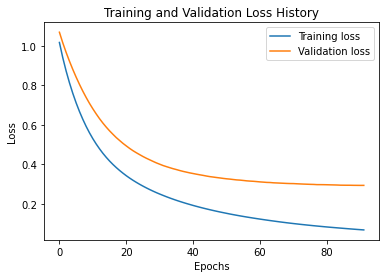

In [37]:
# Plotting the Loss history 

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [38]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8487208008898777
Precision: 0.8512270784089923
Recall: 0.848695652173913
F1-Score: 0.848831898522301


### Discuss how did you choose model hyperparameters ? 

In [39]:
#Calculating the best model hyperparameters using a grid search algorithm

embedding_size_list = [200,100, 50]
learning_rate_list = [0.01,0.05, 0.1]
drop_out_rate_list = [0.4, 0.2,0.1]
Accuracy = []
Fmeasure_list = []
para_list = []

for dim in embedding_size_list:
    for lr in learning_rate_list:
        for drop in drop_out_rate_list:
            W = network_weights(vocab_size=len(vocab), 
                    embedding_dim=dim, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5)
            
           # We replace the dim, drop and lr for each iteration
            W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, dropout = drop,freeze_emb=False,tolerance=0.1,epochs=100,print_progress=True)           
            
            # obtaining the Results and Scores with different combination
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,test_class)]
            accuracy = accuracy_score(test_class,preds_te)
            precision = precision_score(Y_te,preds_te,average='macro')
            Recall =recall_score(Y_te,preds_te,average='macro')
            F_Score =f1_score(Y_te,preds_te,average='macro')
            score = [accuracy, precision, Recall,F_Score]
            
            Accuracy.append(accuracy)
            Fmeasure_list.append([accuracy, precision, Recall, F_Score])
            para = [dim, lr, drop]
            para_list.append(para)

Epoch 1: train loss 0.6072, val loss 0.7376
Epoch 2: train loss 0.3633, val loss 0.4942
Epoch 3: train loss 0.2640, val loss 0.3666
Epoch 4: train loss 0.2045, val loss 0.3162
Epoch 5: train loss 0.1586, val loss 0.2946
Epoch 6: train loss 0.1288, val loss 0.2805
Epoch 7 stopped early: train loss 0.1038, val loss 0.2838
Epoch 1: train loss 0.6616, val loss 0.7921
Epoch 2: train loss 0.4194, val loss 0.5501
Epoch 3: train loss 0.3021, val loss 0.4260
Epoch 4: train loss 0.2313, val loss 0.3745
Epoch 5: train loss 0.1850, val loss 0.3388
Epoch 6: train loss 0.1502, val loss 0.3198
Epoch 7: train loss 0.1222, val loss 0.3146
Epoch 8: train loss 0.1013, val loss 0.3129
Epoch 9: train loss 0.0855, val loss 0.3105
Epoch 10: train loss 0.0722, val loss 0.3081
Epoch 11 stopped early: train loss 0.0615, val loss 0.3095
Epoch 1: train loss 0.6354, val loss 0.7302
Epoch 2: train loss 0.4135, val loss 0.5236
Epoch 3: train loss 0.3010, val loss 0.4292
Epoch 4: train loss 0.2327, val loss 0.3642
Ep

### Find out the best Hyperparameters

We can use a grid search algorithm to find the best combination of hyperparameters for our model. The hyperparameters that are being varied in this grid search are the learning rate, embedding size, and dropout rate.

For each combination of hyperparameters, the function trains the model using the SGD function and computes the accuracy, precision, recall, and F1-score on a test dataset. The results for each combination of hyperparameters are stored in test_score, all_list, and hyper_list.

The test_score list keeps track of the accuracy scores for each iteration, while all_list stores the scores for all four evaluation metrics. The hyper_list keeps track of the hyperparameters for each iteration.

By performing a grid search over the hyperparameters in this way, we can determine the best combination of hyperparameters for our model, which can improve its performance on unseen data.


In [40]:
#Computing the result for the combination of best hyperparameters

best_result = max(Accuracy)
best_id = Accuracy.index(best_result)
best_para = para_list[best_id]
best_S = Fmeasure_list[best_id]
print("The best Hyperparameters and the F1-score on the test set are:")
print("embedding_dim:", best_para[0], " lr:", best_para[1]," drop_rate:" ,best_para[2] ," Accuracy:", best_result, "F measures: A/P/R/F",best_S)

The best Hyperparameters and the F1-score on the test set are:
embedding_dim: 100  lr: 0.01  drop_rate: 0.4  Accuracy: 0.8598442714126807 F measures: A/P/R/F [0.8598442714126807, 0.8612231315292967, 0.859817911557042, 0.8598021609989694]


### HyperParameters selection

As per the results obtained after the grid search algorithm I observe the following best hyperparameters-

Embedding_dim = 100
learning rate = 0.01
dropout_rate = 0.4

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [41]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [42]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",wordtovocab_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [43]:
# Initialise the weights of your network 
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)

#Replace the weigths of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.01,
                                       dropout = drop,freeze_emb = True,tolerance=0.001,epochs=100)

Shape W0 (2000, 300)
Shape W1 (300, 3)
Epoch 1: train loss 0.5543, val loss 0.5860
Epoch 2: train loss 0.4484, val loss 0.4626
Epoch 3: train loss 0.4054, val loss 0.4030
Epoch 4: train loss 0.3906, val loss 0.3843
Epoch 5: train loss 0.3747, val loss 0.3439
Epoch 6: train loss 0.3619, val loss 0.3333
Epoch 7: train loss 0.3539, val loss 0.3138
Epoch 8: train loss 0.3477, val loss 0.3040
Epoch 9: train loss 0.3428, val loss 0.3035
Epoch 10 stopped early: train loss 0.3447, val loss 0.3107


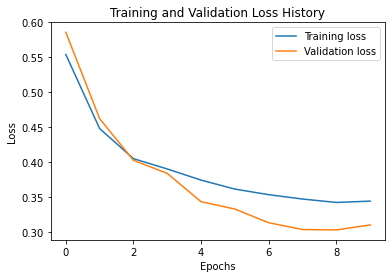

In [44]:
# Plotting the Loss history 

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

In [45]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8687430478309233
Precision: 0.8746289515573427
Recall: 0.8687551096246748
F1-Score: 0.8698793873203966


### Discuss how did you choose model hyperparameters ? 

In [46]:
#Calculating the best model hyperparameters using a grid search algorithm

learning_rate_list = [0.01, 0.05, 0.1]
drop_out_rate_list = [0.4, 0.2, 0.1]
Accuracy = []
Fmeasure_list = []
para_list = []

for lr in learning_rate_list:
    for drop in drop_out_rate_list:
        # Initialise the weights of your network 
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)
            #Replace the weigths of the embedding matrix with w_glove
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, dropout = drop,freeze_emb=False,tolerance=0.01,epochs=100,print_progress=True)
   
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_tr,train_class)]
        tr_f1 = f1_score(train_class,preds_te,average='macro')
            
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,test_class)]
        accuracy = accuracy_score(test_class,preds_te)
        precision = precision_score(Y_te,preds_te,average='macro')
        Recall =recall_score(Y_te,preds_te,average='macro')
        F_Score =f1_score(Y_te,preds_te,average='macro')
        score = [accuracy, precision, Recall,F_Score]
            
        Accuracy.append(accuracy)
        Fmeasure_list.append([accuracy, precision, Recall, F_Score])
        para = [dim, lr, drop]
        para_list.append(para)

Epoch 1: train loss 0.4184, val loss 0.4682
Epoch 2: train loss 0.3301, val loss 0.3108
Epoch 3: train loss 0.3298, val loss 0.2959
Epoch 4 stopped early: train loss 0.2943, val loss 0.3180
Epoch 1: train loss 0.2508, val loss 0.3147
Epoch 2: train loss 0.2149, val loss 0.2704
Epoch 3: train loss 0.1896, val loss 0.2642
Epoch 4 stopped early: train loss 0.1634, val loss 0.2803
Epoch 1: train loss 0.2116, val loss 0.3104
Epoch 2: train loss 0.1708, val loss 0.2684
Epoch 3: train loss 0.1490, val loss 0.2552
Epoch 4 stopped early: train loss 0.1322, val loss 0.2631
Epoch 1: train loss 0.2255, val loss 0.4152
Epoch 2 stopped early: train loss 0.1834, val loss 0.6140
Epoch 1: train loss 0.0650, val loss 0.3223
Epoch 2 stopped early: train loss 0.0440, val loss 0.3596
Epoch 1: train loss 0.0445, val loss 0.3374
Epoch 2 stopped early: train loss 0.0298, val loss 0.3423
Epoch 1: train loss 0.2513, val loss 1.0762
Epoch 2 stopped early: train loss 0.1421, val loss 1.2062
Epoch 1: train loss 0.

In [47]:
#Computing the result for the combination of best hyperparameters

best_result = max(Accuracy)
best_id = Accuracy.index(best_result)
best_para = para_list[best_id]
best_S = Fmeasure_list[best_id]
print("The best Hyperparameters and the F1-score on the test set are:")
print("embedding_dim:", best_para[0], " lr:", best_para[1]," drop_rate:" ,best_para[2] ," Accuracy:", best_result, "F measures: A/P/R/F",best_S)

The best Hyperparameters and the F1-score on the test set are:
embedding_dim: 50  lr: 0.01  drop_rate: 0.4  Accuracy: 0.8776418242491657 F measures: A/P/R/F [0.8776418242491657, 0.8778055578988848, 0.8776031215161652, 0.8769721541366806]


# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [ ]:
def backward_pass(x, y, W, out_vals, lr=0.01, freeze_emb=False):
    
    # Initialize gradients
    dW = [np.zeros_like(w) for w in W]
    
    # Compute error at output layer
    error = out_vals['y']
    error[y] -= 1
    
    # Backpropagate error through output layer
    dW[-1] = np.outer(out_vals['a'][-1], error)
    delta = error
    
    # Backpropagate error through hidden layers
    for i in range(len(W) - 2, 0, -1):
        # Retrieve dropout mask for current layer
        dropout = out_vals['dropout_vecs'][i-1]
        # Compute delta for current layer
        delta = np.dot(W[i+1], delta) * relu_derivative(out_vals['h'][i])
        delta *= dropout
        # Compute gradients for current layer
        dW[i] = np.outer(out_vals['a'][i], delta)
    
    # Backpropagate error through input layer
    delta = np.dot(W[1], delta) * relu_derivative(out_vals['h'][0])
    dW[0] = np.zeros_like(W[0])
    for i in x:
        dW[0][i,:] += delta
    if freeze_emb:
        dW[0] = np.zeros_like(W[0])
    
    # Update weights
    for i in range(len(W)):
        W[i] -= lr * dW[i]
    
    return W


In [49]:
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[300], num_classes=3, init_val=0.1)
W[0] = w_glove
for i in range(len(W)):
    print('Shape of W' + str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=0.001, dropout=0.2, freeze_emb=True,
                            print_progress=True, tolerance=0.00001, epochs=30)


Shape of W0 (2000, 300)
Shape of W1 (300, 300)
Shape of W2 (300, 3)
Epoch 1: train loss 0.5706, val loss 0.6889
Epoch 2: train loss 0.3294, val loss 0.4885
Epoch 3: train loss 0.2165, val loss 0.3952
Epoch 4: train loss 0.1633, val loss 0.3527
Epoch 5: train loss 0.1363, val loss 0.3286
Epoch 6: train loss 0.1222, val loss 0.3232
Epoch 7: train loss 0.1155, val loss 0.3157
Epoch 8: train loss 0.1123, val loss 0.3149
Epoch 9: train loss 0.1139, val loss 0.3053
Epoch 10 stopped early: train loss 0.1111, val loss 0.3110


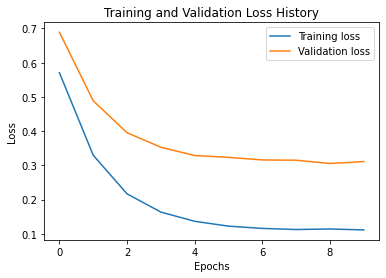

In [50]:
# Plotting the Loss history 

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

In [51]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8264738598442715
Precision: 0.8272272252030403
Recall: 0.8264437012263098
F1-Score: 0.8257476264906649


### Discuss how did you choose model hyperparameters ? 

In [54]:
#Calculating the best model hyperparameters using a grid search algorithm and using all possible combinations of the Hyperparameters

learning_rate_list = [0.001,0.01,0.05]
drop_out_rate_list = [0.01, 0.2, 0.4 ]
Accuracy = []
Fmeasure_list = []
para_list = []

for lr in learning_rate_list:
    for drop in drop_out_rate_list:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[300],num_classes=3, init_val = 0.1)
            #Replace the weigths of the embedding matrix with w_glove
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, 
                                   dropout = drop,freeze_emb=False,tolerance=0.1,epochs=100,print_progress=True)    
        # Results and Scores
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,test_class)]
        accuracy = accuracy_score(test_class,preds_te)
        precision = precision_score(Y_te,preds_te,average='macro')
        Recall =recall_score(Y_te,preds_te,average='macro')
        F_Score =f1_score(Y_te,preds_te,average='macro')
        score = [accuracy, precision, Recall,F_Score]
            
        Accuracy.append(accuracy)
        Fmeasure_list.append([accuracy, precision, Recall, F_Score])
        para = [dim, lr, drop]
        para_list.append(para)

Epoch 1: train loss 0.4560, val loss 0.5867
Epoch 2: train loss 0.2481, val loss 0.4195
Epoch 3: train loss 0.1705, val loss 0.3628
Epoch 4: train loss 0.1329, val loss 0.3430
Epoch 5: train loss 0.1118, val loss 0.3333
Epoch 6: train loss 0.0984, val loss 0.3287
Epoch 7: train loss 0.0895, val loss 0.3277
Epoch 8 stopped early: train loss 0.0831, val loss 0.3288
Epoch 1: train loss 0.5610, val loss 0.6770
Epoch 2: train loss 0.3045, val loss 0.4700
Epoch 3: train loss 0.1866, val loss 0.3822
Epoch 4: train loss 0.1336, val loss 0.3446
Epoch 5: train loss 0.1023, val loss 0.3299
Epoch 6: train loss 0.0853, val loss 0.3247
Epoch 7 stopped early: train loss 0.0738, val loss 0.3266
Epoch 1: train loss 0.5988, val loss 0.6922
Epoch 2: train loss 0.3268, val loss 0.4662
Epoch 3: train loss 0.1898, val loss 0.3499
Epoch 4: train loss 0.1223, val loss 0.3007
Epoch 5: train loss 0.0897, val loss 0.2817
Epoch 6 stopped early: train loss 0.0739, val loss 0.2853
Epoch 1: train loss 0.0781, val lo

In [55]:
#Computing the result for the combination of best hyperparameters

best_result = max(Accuracy)
best_id = Accuracy.index(best_result)
best_para = para_list[best_id]
best_S = Fmeasure_list[best_id]
print("The best Hyperparameters and the F1-score on the test set are:")
print("embedding_dim:", best_para[0], " lr:", best_para[1]," drop_rate:" ,best_para[2] ," Accuracy:", best_result, "F measures: A/P/R/F",best_S)

The best Hyperparameters and the F1-score on the test set are:
embedding_dim: 50  lr: 0.01  drop_rate: 0.4  Accuracy: 0.8654060066740823 F measures: A/P/R/F [0.8654060066740823, 0.868037103662937, 0.8653920475659606, 0.8649193899657908]


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |0.8612231315292967   |0.859817911557042   |0.8598021609989694   |0.8598442714126807   |
| Average Embedding (Pre-trained)  |0.8778055578988848   |0.8776031215161652   |0.8769721541366806   |0.8776418242491657   |
| Average Embedding (Pre-trained) + X hidden layers    |0.868037103662937  |0.8653920475659606   |0.8649193899657908   |0.8654060066740823   |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.


The impact of deeper architectures on performance depends on the specific model and data.

Deeper architectures often allow the network to learn more intricate and abstract representations of the input data, which may increase performance. Deeper designs, however, can raise the chance of overfitting, particularly if the data is sparse or chaotic.

I get better results with my Pre-trained model - This signfies that my  pre-trained embeddings are better suited to the task at hand than the embeddings learned during training.

Maybe with more model training my Hidden Layers model can obtain better results.